# Multivariate time series prediction

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo4/init.py
from init import init; init(force_download=False)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load data:

In [2]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('local/data/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('local/data/pollution.csv',compression='gzip')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


Let's take a look at the time series:

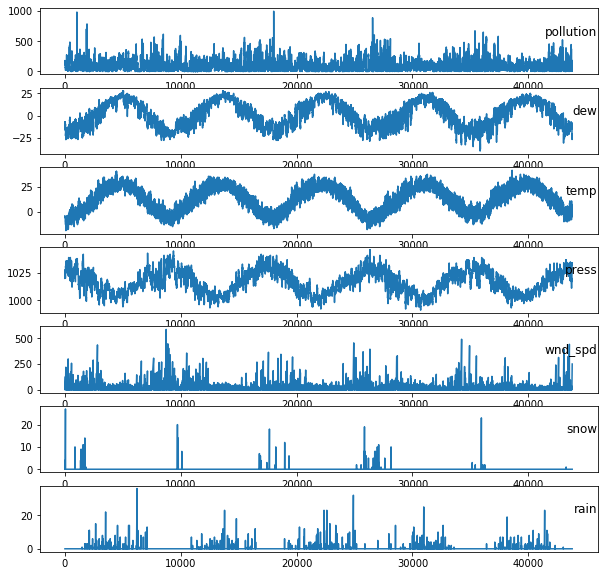

In [3]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('local/data/pollution.csv', compression='gzip', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(10,10))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [4]:
dataset.columns[0]

'pollution'

## Exercise 1

Create three models: one based on conventional RNNs, one based on LSTM and a last one based on GRU units. Compare the performance of the models predicting one step forward. For all the models use one recurrent layer with 50 neurons.

### Solution:

The original data is organized in a matrix where rows are observations and columns are variables.



First of all, create a function to format the data as the model requires: [n_samples,n_times,n_features]

In [17]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [18]:
Eje_serie = np.arange(20)
print(Eje_serie)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [19]:
create_dataset(Eje_serie, look_back=3)

(array([[ 0,  1,  2],
        [ 1,  2,  3],
        [ 2,  3,  4],
        [ 3,  4,  5],
        [ 4,  5,  6],
        [ 5,  6,  7],
        [ 6,  7,  8],
        [ 7,  8,  9],
        [ 8,  9, 10],
        [ 9, 10, 11],
        [10, 11, 12],
        [11, 12, 13],
        [12, 13, 14],
        [13, 14, 15],
        [14, 15, 16],
        [15, 16, 17],
        [16, 17, 18]]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))

#### But our dataset is Multivariate, so we need to make a small change to the former function:

In [22]:
def create_datasetMV(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
Eje_serie = np.r_[np.arange(20).reshape(1,-1),np.arange(20,40).reshape(1,-1)]
print(Eje_serie)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]]


In [32]:
X,Y = create_datasetMV(Eje_serie.T, look_back=2)
X.shape,Y.shape

((18, 2, 2), (18,))

In [38]:
X[0,:,:]

array([[ 0, 20],
       [ 1, 21]])

In [37]:
Y[0]

2

Now we can define a function that help us we the partition of the data and the creation of training and testing sets.

In [51]:
from sklearn.preprocessing import MinMaxScaler
def DataPreparation(look_back):
    times = values.shape[0]
    # split into train and test sets
    train_size = int(times * 0.67)
    test_size = times - train_size
    train, test = values[0:train_size,groups], values[train_size-look_back:times,groups]
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainN = scaler.fit_transform(train)
    testN = scaler.transform(test)
    X_train, y_train = create_datasetMV(trainN, look_back)
    X_test, y_test = create_datasetMV(testN, look_back)
    # Defino un scaler s贸lo para poluci贸n
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train[:,0].reshape(-1,1))
    return X_train, y_train, X_test, y_test, scaler

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import datetime

In [67]:
def TrainModel(X_train,y_train,layer='SimpleRNN'):
    model = Sequential()
    if layer == 'LSTM':
        model.add(LSTM(50,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    elif layer == 'GRU':
        model.add(GRU(50,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    else:
        model.add(SimpleRNN(50,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
        
    model.add(Dense(1))
    Optimi = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=Optimi,loss='mse',metrics=['mae'])
    #-------------------------------------------------------------------------------------------------
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    #-------------------------------------------------------------------------------------------------
    #We could use validation_split=0.1
    #stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    model.fit(X_train,y_train,epochs=50, verbose=1, callbacks=[tensorboard_callback])
    return model

In [73]:
from numpy.random import seed
#tf.keras.backend.clear_session()
seed(1)
tf.random.set_seed(2)
from sklearn.metrics import mean_squared_error
tf.keras.backend.clear_session()
look_back = 1

X_train, y_train, X_test, y_test, scaler = DataPreparation(look_back)
model = TrainModel(X_train,y_train)
y_est = model.predict(X_test)
print('RMSE con los datos normalizados')
print(np.sqrt(mean_squared_error(y_test.flatten(), y_est.flatten())))
print('RMSE con los datos en la magnitud original')
print(np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est))))

Train on 29345 samples
Epoch 1/50
29345/29345 [==============================] - 2s 80us/sample - loss: 0.0066 - mae: 0.0534
Epoch 2/50
29345/29345 [==============================] - 2s 64us/sample - loss: 0.0013 - mae: 0.0231
Epoch 3/50
29345/29345 [==============================] - 2s 66us/sample - loss: 9.0981e-04 - mae: 0.0168
Epoch 4/50
29345/29345 [==============================] - 2s 69us/sample - loss: 8.6398e-04 - mae: 0.0156
Epoch 5/50
29345/29345 [==============================] - 2s 68us/sample - loss: 8.4622e-04 - mae: 0.0151
Epoch 6/50
29345/29345 [==============================] - 2s 69us/sample - loss: 8.3990e-04 - mae: 0.0149
Epoch 7/50
29345/29345 [==============================] - 2s 70us/sample - loss: 8.3728e-04 - mae: 0.0149
Epoch 8/50
29345/29345 [==============================] - 2s 69us/sample - loss: 8.3483e-04 - mae: 0.0148
Epoch 9/50
29345/29345 [==============================] - 2s 69us/sample - loss: 8.3379e-04 - mae: 0.0147
Epoch 10/50
29345/29345 [======

In [75]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [74]:
#!kill 28450

In [82]:
def TrainModel2(X_train,y_train,layer='SimpleRNN'):
    model = Sequential()
    if layer == 'LSTM':
        model.add(LSTM(50,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    elif layer == 'GRU':
        model.add(GRU(50,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    else:
        model.add(SimpleRNN(50,activation = 'relu',input_shape=(X_train.shape[1],X_train.shape[2])))
        
    model.add(Dense(1))
    Optimi = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=Optimi,loss='mse',metrics=['mae'])
    #-------------------------------------------------------------------------------------------------
    #log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    #-------------------------------------------------------------------------------------------------
    #We could use validation_split=0.1
    stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    model.fit(X_train,y_train,epochs=20, validation_split=0.1, verbose=1, callbacks=[stop])
    return model

In [83]:
mse = np.zeros((3,5))
for i in range(1,6):
    for j,k in enumerate(['LSTM','GRU','SimpleRNN']):
        X_train, y_train, X_test, y_test, scaler = DataPreparation(i)
        model = TrainModel2(X_train,y_train,layer=k)
        y_est = model.predict(X_test)
        mse[j,i-1] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est)))

Train on 26410 samples, validate on 2935 samples
Epoch 1/20
26410/26410 [==============================] - 3s 105us/sample - loss: 0.0091 - mae: 0.0666 - val_loss: 0.0126 - val_mae: 0.0724
Epoch 2/20
26410/26410 [==============================] - 2s 78us/sample - loss: 0.0038 - mae: 0.0437 - val_loss: 0.0058 - val_mae: 0.0477
Epoch 3/20
26410/26410 [==============================] - 2s 75us/sample - loss: 0.0016 - mae: 0.0275 - val_loss: 0.0026 - val_mae: 0.0297
Epoch 4/20
26410/26410 [==============================] - 2s 80us/sample - loss: 9.1607e-04 - mae: 0.0184 - val_loss: 0.0019 - val_mae: 0.0230
Epoch 5/20
26410/26410 [==============================] - 2s 80us/sample - loss: 7.9777e-04 - mae: 0.0158 - val_loss: 0.0017 - val_mae: 0.0210
Epoch 6/20
26410/26410 [==============================] - 2s 80us/sample - loss: 7.7250e-04 - mae: 0.0149 - val_loss: 0.0017 - val_mae: 0.0204
Epoch 7/20
26410/26410 [==============================] - 2s 85us/sample - loss: 7.6450e-04 - mae: 0.014

Epoch 3/20
26409/26409 [==============================] - 4s 165us/sample - loss: 0.0010 - mae: 0.0181 - val_loss: 0.0022 - val_mae: 0.0246
Epoch 4/20
26409/26409 [==============================] - 4s 137us/sample - loss: 0.0010 - mae: 0.0176 - val_loss: 0.0021 - val_mae: 0.0241
Epoch 5/20
26409/26409 [==============================] - 3s 98us/sample - loss: 9.9082e-04 - mae: 0.0173 - val_loss: 0.0020 - val_mae: 0.0237
Epoch 6/20
26409/26409 [==============================] - 4s 133us/sample - loss: 9.7526e-04 - mae: 0.0172 - val_loss: 0.0020 - val_mae: 0.0232
Epoch 7/20
26409/26409 [==============================] - 4s 138us/sample - loss: 9.5819e-04 - mae: 0.0170 - val_loss: 0.0019 - val_mae: 0.0227
Epoch 8/20
26409/26409 [==============================] - 5s 188us/sample - loss: 9.4192e-04 - mae: 0.0168 - val_loss: 0.0019 - val_mae: 0.0229
Epoch 9/20
26409/26409 [==============================] - 6s 215us/sample - loss: 9.2920e-04 - mae: 0.0167 - val_loss: 0.0019 - val_mae: 0.0225
E

26409/26409 [==============================] - 2s 77us/sample - loss: 7.2475e-04 - mae: 0.0140 - val_loss: 0.0017 - val_mae: 0.0187
Epoch 20/20
26409/26409 [==============================] - 2s 79us/sample - loss: 7.2249e-04 - mae: 0.0139 - val_loss: 0.0017 - val_mae: 0.0193
Train on 26408 samples, validate on 2935 samples
Epoch 1/20
26408/26408 [==============================] - 5s 185us/sample - loss: 0.0044 - mae: 0.0456 - val_loss: 0.0043 - val_mae: 0.0394
Epoch 2/20
26408/26408 [==============================] - 5s 203us/sample - loss: 0.0014 - mae: 0.0232 - val_loss: 0.0026 - val_mae: 0.0286
Epoch 3/20
26408/26408 [==============================] - 4s 160us/sample - loss: 0.0012 - mae: 0.0201 - val_loss: 0.0024 - val_mae: 0.0270
Epoch 4/20
26408/26408 [==============================] - 5s 186us/sample - loss: 0.0011 - mae: 0.0192 - val_loss: 0.0023 - val_mae: 0.0259
Epoch 5/20
26408/26408 [==============================] - 6s 241us/sample - loss: 0.0011 - mae: 0.0187 - val_loss: 

26408/26408 [==============================] - 2s 89us/sample - loss: 7.4095e-04 - mae: 0.0143 - val_loss: 0.0015 - val_mae: 0.0192
Epoch 16/20
26408/26408 [==============================] - 2s 90us/sample - loss: 7.4079e-04 - mae: 0.0144 - val_loss: 0.0015 - val_mae: 0.0192
Epoch 17/20
26408/26408 [==============================] - 2s 86us/sample - loss: 7.4128e-04 - mae: 0.0143 - val_loss: 0.0015 - val_mae: 0.0189
Epoch 18/20
26408/26408 [==============================] - 2s 89us/sample - loss: 7.3563e-04 - mae: 0.0142 - val_loss: 0.0015 - val_mae: 0.0188
Epoch 19/20
26408/26408 [==============================] - 2s 87us/sample - loss: 7.3797e-04 - mae: 0.0143 - val_loss: 0.0015 - val_mae: 0.0189
Epoch 20/20
26408/26408 [==============================] - 2s 87us/sample - loss: 7.3677e-04 - mae: 0.0143 - val_loss: 0.0015 - val_mae: 0.0194
Train on 26407 samples, validate on 2935 samples
Epoch 1/20
26407/26407 [==============================] - 5s 172us/sample - loss: 0.0045 - mae: 0.0

26407/26407 [==============================] - 3s 99us/sample - loss: 7.5387e-04 - mae: 0.0146 - val_loss: 0.0016 - val_mae: 0.0193
Epoch 12/20
26407/26407 [==============================] - 3s 98us/sample - loss: 7.4972e-04 - mae: 0.0145 - val_loss: 0.0016 - val_mae: 0.0193
Epoch 13/20
26407/26407 [==============================] - 2s 88us/sample - loss: 7.4522e-04 - mae: 0.0144 - val_loss: 0.0016 - val_mae: 0.0193
Epoch 14/20
26407/26407 [==============================] - 2s 93us/sample - loss: 7.4435e-04 - mae: 0.0144 - val_loss: 0.0015 - val_mae: 0.0190
Epoch 15/20
26407/26407 [==============================] - 2s 94us/sample - loss: 7.4558e-04 - mae: 0.0145 - val_loss: 0.0015 - val_mae: 0.0188
Epoch 16/20
26407/26407 [==============================] - 2s 95us/sample - loss: 7.3802e-04 - mae: 0.0143 - val_loss: 0.0016 - val_mae: 0.0195
Epoch 17/20
26407/26407 [==============================] - 3s 96us/sample - loss: 7.3739e-04 - mae: 0.0143 - val_loss: 0.0016 - val_mae: 0.0192
Epoc

26406/26406 [==============================] - 3s 108us/sample - loss: 7.9726e-04 - mae: 0.0158 - val_loss: 0.0016 - val_mae: 0.0207
Epoch 8/20
26406/26406 [==============================] - 4s 137us/sample - loss: 7.7881e-04 - mae: 0.0155 - val_loss: 0.0017 - val_mae: 0.0227
Epoch 9/20
26406/26406 [==============================] - 3s 106us/sample - loss: 7.6982e-04 - mae: 0.0152 - val_loss: 0.0016 - val_mae: 0.0202
Epoch 10/20
26406/26406 [==============================] - 3s 100us/sample - loss: 7.6105e-04 - mae: 0.0150 - val_loss: 0.0016 - val_mae: 0.0199
Epoch 11/20
26406/26406 [==============================] - 3s 119us/sample - loss: 7.5245e-04 - mae: 0.0149 - val_loss: 0.0016 - val_mae: 0.0195
Epoch 12/20
26406/26406 [==============================] - 3s 102us/sample - loss: 7.4981e-04 - mae: 0.0148 - val_loss: 0.0016 - val_mae: 0.0192
Epoch 13/20
26406/26406 [==============================] - 3s 99us/sample - loss: 7.4321e-04 - mae: 0.0146 - val_loss: 0.0016 - val_mae: 0.0191


Text(0.5, 1.0, 'Performance using RNN')

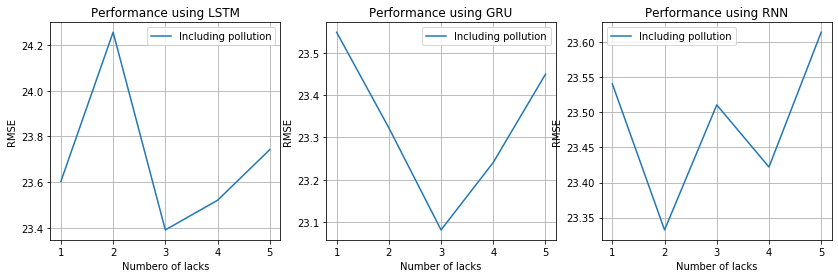

In [84]:
look_back = range(1,6)
pyplot.figure(figsize=(14,4))
pyplot.subplot(131)
pyplot.plot(look_back,mse[0,:],label='Including pollution')
#pyplot.plot(look_back,mse2[0,:],label='without pollution')
pyplot.xlabel('Numbero of lacks')
pyplot.ylabel('RMSE')
pyplot.legend()
pyplot.grid()
pyplot.title('Performance using LSTM')
pyplot.subplot(132)
pyplot.plot(look_back,mse[1,:],label='Including pollution')
#pyplot.plot(look_back,mse2[1,:],label='without pollution')
pyplot.xlabel('Number of lacks')
pyplot.ylabel('RMSE')
pyplot.legend()
pyplot.grid()
pyplot.title('Performance using GRU')
pyplot.subplot(133)
pyplot.plot(look_back,mse[2,:],label='Including pollution')
#pyplot.plot(look_back,mse2[2,:],label='without pollution')
pyplot.xlabel('Number of lacks')
pyplot.ylabel('RMSE')
pyplot.legend()
pyplot.grid()
pyplot.title('Performance using RNN')

In [86]:
X_train, y_train, X_test, y_test, scaler = DataPreparation(3)
model = TrainModel2(X_train,y_train,'GRU')
y_est = model.predict(X_test)

Train on 26408 samples, validate on 2935 samples
Epoch 1/20
26408/26408 [==============================] - 6s 224us/sample - loss: 0.0045 - mae: 0.0447 - val_loss: 0.0029 - val_mae: 0.0300
Epoch 2/20
26408/26408 [==============================] - 6s 225us/sample - loss: 0.0011 - mae: 0.0187 - val_loss: 0.0022 - val_mae: 0.0246
Epoch 3/20
26408/26408 [==============================] - 5s 203us/sample - loss: 9.7861e-04 - mae: 0.0175 - val_loss: 0.0020 - val_mae: 0.0237
Epoch 4/20
26408/26408 [==============================] - 6s 244us/sample - loss: 9.3506e-04 - mae: 0.0169 - val_loss: 0.0019 - val_mae: 0.0228
Epoch 5/20
26408/26408 [==============================] - 7s 258us/sample - loss: 8.9607e-04 - mae: 0.0164 - val_loss: 0.0018 - val_mae: 0.0221
Epoch 6/20
26408/26408 [==============================] - 7s 250us/sample - loss: 8.5946e-04 - mae: 0.0160 - val_loss: 0.0017 - val_mae: 0.0213
Epoch 7/20
26408/26408 [==============================] - 5s 187us/sample - loss: 8.2923e-04 - 

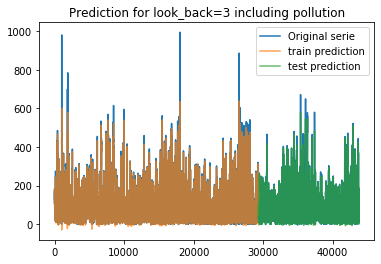

In [89]:
times = values.shape[0]
train_size = int(times * 0.67)
    
y_est_t = model.predict(X_train)
trainPredictPlot = np.empty_like(values[:,0])
trainPredictPlot[:] = np.nan
trainPredictPlot[3:train_size] = scaler.inverse_transform(y_est_t).flatten()
testPredictPlot = np.empty_like(values[:,0])
testPredictPlot[:] = np.nan
testPredictPlot[train_size:] = scaler.inverse_transform(y_est).flatten()
pyplot.figure()
pyplot.plot(values[:,0],label='Original serie')
pyplot.plot(trainPredictPlot,label='train prediction',alpha=0.7)
pyplot.plot(testPredictPlot,label='test prediction',alpha=0.7)
pyplot.title('Prediction for look_back=3 including pollution')
pyplot.legend()

## Excercise 2

Repeat the exercise using crossvalidation and include the confidence interval in the plot.

In [90]:
def DataPreparationCV(look_back,train_index):
    times = values.shape[0]
    # split into train and test sets
    train_size = len(train_index)
    test_size = times - train_size
    train, test = values[0:train_size,groups], values[train_size-look_back:times,groups]
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainN = scaler.fit_transform(train)
    testN = scaler.transform(test)
    X_train, y_train = create_datasetMV(trainN, look_back)
    X_test, y_test = create_datasetMV(testN, look_back)
    # Defino un scaler s贸lo para poluci贸n
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train[:,0].reshape(-1,1))
    return X_train, y_train, X_test, y_test, scaler

In [92]:
from sklearn.model_selection import TimeSeriesSplit
X = np.arange(times)
tscv = TimeSeriesSplit(n_splits=5)
l=-1
mse = np.zeros((2,5,5))
for train_index, test_index in tscv.split(X): 
    l += 1
    for i in range(1,6):
        for j,k in enumerate(['LSTM','GRU',]):
            X_train, y_train, X_test, y_test, scaler = DataPreparationCV(i,train_index)
            model = TrainModel2(X_train,y_train,layer=k)
            y_est = model.predict(X_test)
            mse[j,i-1,l] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est)))

Train on 6569 samples, validate on 730 samples
Epoch 1/20
6569/6569 [==============================] - 1s 163us/sample - loss: 0.0076 - mae: 0.0617 - val_loss: 0.0152 - val_mae: 0.0833
Epoch 2/20
6569/6569 [==============================] - 1s 78us/sample - loss: 0.0055 - mae: 0.0553 - val_loss: 0.0129 - val_mae: 0.0783
Epoch 3/20
6569/6569 [==============================] - 1s 93us/sample - loss: 0.0048 - mae: 0.0515 - val_loss: 0.0109 - val_mae: 0.0710
Epoch 4/20
6569/6569 [==============================] - 1s 85us/sample - loss: 0.0042 - mae: 0.0475 - val_loss: 0.0093 - val_mae: 0.0653
Epoch 5/20
6569/6569 [==============================] - 1s 84us/sample - loss: 0.0036 - mae: 0.0440 - val_loss: 0.0079 - val_mae: 0.0589
Epoch 6/20
6569/6569 [==============================] - 1s 79us/sample - loss: 0.0031 - mae: 0.0402 - val_loss: 0.0062 - val_mae: 0.0539
Epoch 7/20
6569/6569 [==============================] - 1s 100us/sample - loss: 0.0025 - mae: 0.0362 - val_loss: 0.0049 - val_mae:

6568/6568 [==============================] - 1s 127us/sample - loss: 0.0011 - mae: 0.0183 - val_loss: 8.5412e-04 - val_mae: 0.0166
Epoch 19/20
6568/6568 [==============================] - 1s 103us/sample - loss: 0.0011 - mae: 0.0181 - val_loss: 8.4686e-04 - val_mae: 0.0166
Epoch 20/20
6568/6568 [==============================] - 1s 90us/sample - loss: 0.0011 - mae: 0.0181 - val_loss: 8.5585e-04 - val_mae: 0.0167
Train on 6568 samples, validate on 730 samples
Epoch 1/20
6568/6568 [==============================] - 1s 189us/sample - loss: 0.0065 - mae: 0.0594 - val_loss: 0.0135 - val_mae: 0.0854
Epoch 2/20
6568/6568 [==============================] - 1s 170us/sample - loss: 0.0047 - mae: 0.0502 - val_loss: 0.0090 - val_mae: 0.0688
Epoch 3/20
6568/6568 [==============================] - 1s 101us/sample - loss: 0.0033 - mae: 0.0412 - val_loss: 0.0054 - val_mae: 0.0547
Epoch 4/20
6568/6568 [==============================] - 1s 98us/sample - loss: 0.0022 - mae: 0.0331 - val_loss: 0.0031 - va

Epoch 16/20
6567/6567 [==============================] - 2s 315us/sample - loss: 0.0010 - mae: 0.0176 - val_loss: 9.6601e-04 - val_mae: 0.0187
Epoch 17/20
6567/6567 [==============================] - 1s 221us/sample - loss: 0.0010 - mae: 0.0174 - val_loss: 9.6557e-04 - val_mae: 0.0192
Epoch 18/20
6567/6567 [==============================] - 1s 175us/sample - loss: 0.0010 - mae: 0.0172 - val_loss: 8.9239e-04 - val_mae: 0.0172
Epoch 19/20
6567/6567 [==============================] - 2s 372us/sample - loss: 0.0010 - mae: 0.0171 - val_loss: 8.5187e-04 - val_mae: 0.0167
Epoch 20/20
6567/6567 [==============================] - 2s 246us/sample - loss: 9.9886e-04 - mae: 0.0168 - val_loss: 8.9512e-04 - val_mae: 0.0175
Train on 6566 samples, validate on 730 samples
Epoch 1/20
6566/6566 [==============================] - 2s 265us/sample - loss: 0.0079 - mae: 0.0646 - val_loss: 0.0150 - val_mae: 0.0851
Epoch 2/20
6566/6566 [==============================] - 1s 222us/sample - loss: 0.0052 - mae: 0.

6565/6565 [==============================] - 1s 143us/sample - loss: 0.0014 - mae: 0.0216 - val_loss: 0.0012 - val_mae: 0.0201
Epoch 14/20
6565/6565 [==============================] - 2s 257us/sample - loss: 0.0013 - mae: 0.0212 - val_loss: 0.0011 - val_mae: 0.0199
Epoch 15/20
6565/6565 [==============================] - 2s 236us/sample - loss: 0.0013 - mae: 0.0209 - val_loss: 0.0011 - val_mae: 0.0195
Epoch 16/20
6565/6565 [==============================] - 1s 224us/sample - loss: 0.0013 - mae: 0.0209 - val_loss: 0.0011 - val_mae: 0.0188
Epoch 17/20
6565/6565 [==============================] - 2s 291us/sample - loss: 0.0013 - mae: 0.0203 - val_loss: 0.0012 - val_mae: 0.0212
Epoch 18/20
6565/6565 [==============================] - 2s 270us/sample - loss: 0.0012 - mae: 0.0204 - val_loss: 0.0011 - val_mae: 0.0200
Epoch 19/20
6565/6565 [==============================] - 1s 216us/sample - loss: 0.0012 - mae: 0.0198 - val_loss: 9.6480e-04 - val_mae: 0.0179
Epoch 20/20
6565/6565 [============

13139/13139 [==============================] - 1s 80us/sample - loss: 8.3290e-04 - mae: 0.0147 - val_loss: 5.4636e-04 - val_mae: 0.0140
Epoch 10/20
13139/13139 [==============================] - 1s 88us/sample - loss: 8.3274e-04 - mae: 0.0147 - val_loss: 5.1215e-04 - val_mae: 0.0127
Epoch 11/20
13139/13139 [==============================] - 1s 83us/sample - loss: 8.2824e-04 - mae: 0.0146 - val_loss: 5.1125e-04 - val_mae: 0.0126
Epoch 12/20
13139/13139 [==============================] - 1s 92us/sample - loss: 8.3134e-04 - mae: 0.0146 - val_loss: 5.1276e-04 - val_mae: 0.0126
Epoch 13/20
13139/13139 [==============================] - 1s 87us/sample - loss: 8.2865e-04 - mae: 0.0145 - val_loss: 5.1914e-04 - val_mae: 0.0130
Epoch 14/20
13139/13139 [==============================] - 2s 122us/sample - loss: 8.2826e-04 - mae: 0.0145 - val_loss: 5.0841e-04 - val_mae: 0.0124
Epoch 15/20
13139/13139 [==============================] - 1s 82us/sample - loss: 8.2602e-04 - mae: 0.0145 - val_loss: 5.08

13137/13137 [==============================] - 3s 226us/sample - loss: 0.0013 - mae: 0.0216 - val_loss: 8.6291e-04 - val_mae: 0.0193
Epoch 5/20
13137/13137 [==============================] - 2s 118us/sample - loss: 0.0013 - mae: 0.0211 - val_loss: 7.8577e-04 - val_mae: 0.0175
Epoch 6/20
13137/13137 [==============================] - 1s 108us/sample - loss: 0.0013 - mae: 0.0208 - val_loss: 7.8715e-04 - val_mae: 0.0176
Epoch 7/20
13137/13137 [==============================] - 2s 160us/sample - loss: 0.0013 - mae: 0.0205 - val_loss: 7.7491e-04 - val_mae: 0.0176
Epoch 8/20
13137/13137 [==============================] - 2s 128us/sample - loss: 0.0012 - mae: 0.0203 - val_loss: 7.4931e-04 - val_mae: 0.0168
Epoch 9/20
13137/13137 [==============================] - 2s 156us/sample - loss: 0.0012 - mae: 0.0199 - val_loss: 7.4347e-04 - val_mae: 0.0171
Epoch 10/20
13137/13137 [==============================] - 2s 125us/sample - loss: 0.0012 - mae: 0.0198 - val_loss: 7.6107e-04 - val_mae: 0.0176
Ep

Epoch 20/20
13136/13136 [==============================] - 2s 166us/sample - loss: 9.3416e-04 - mae: 0.0168 - val_loss: 5.5136e-04 - val_mae: 0.0139
Train on 13136 samples, validate on 1460 samples
Epoch 1/20
13136/13136 [==============================] - 3s 234us/sample - loss: 0.0071 - mae: 0.0569 - val_loss: 0.0021 - val_mae: 0.0363
Epoch 2/20
13136/13136 [==============================] - 3s 240us/sample - loss: 0.0018 - mae: 0.0268 - val_loss: 7.1774e-04 - val_mae: 0.0172
Epoch 3/20
13136/13136 [==============================] - 4s 271us/sample - loss: 0.0012 - mae: 0.0201 - val_loss: 6.7175e-04 - val_mae: 0.0158
Epoch 4/20
13136/13136 [==============================] - 3s 219us/sample - loss: 0.0011 - mae: 0.0189 - val_loss: 6.4318e-04 - val_mae: 0.0150
Epoch 5/20
13136/13136 [==============================] - 2s 161us/sample - loss: 0.0011 - mae: 0.0184 - val_loss: 6.3754e-04 - val_mae: 0.0151
Epoch 6/20
13136/13136 [==============================] - 3s 214us/sample - loss: 0.00

13135/13135 [==============================] - 2s 185us/sample - loss: 8.3020e-04 - mae: 0.0152 - val_loss: 5.0595e-04 - val_mae: 0.0129
Epoch 16/20
13135/13135 [==============================] - 4s 284us/sample - loss: 8.2549e-04 - mae: 0.0151 - val_loss: 5.0408e-04 - val_mae: 0.0128
Epoch 17/20
13135/13135 [==============================] - 4s 298us/sample - loss: 8.2076e-04 - mae: 0.0150 - val_loss: 5.0466e-04 - val_mae: 0.0128
Epoch 18/20
13135/13135 [==============================] - 5s 403us/sample - loss: 8.1621e-04 - mae: 0.0149 - val_loss: 5.1205e-04 - val_mae: 0.0129
Epoch 19/20
13135/13135 [==============================] - 4s 267us/sample - loss: 8.1734e-04 - mae: 0.0149 - val_loss: 5.0311e-04 - val_mae: 0.0128
Epoch 20/20
13135/13135 [==============================] - 3s 243us/sample - loss: 8.1547e-04 - mae: 0.0149 - val_loss: 5.1168e-04 - val_mae: 0.0129
Train on 19709 samples, validate on 2190 samples
Epoch 1/20
19709/19709 [==============================] - 2s 112us/sa

19708/19708 [==============================] - 2s 96us/sample - loss: 0.0010 - mae: 0.0177 - val_loss: 8.1650e-04 - val_mae: 0.0173
Epoch 11/20
19708/19708 [==============================] - 2s 97us/sample - loss: 0.0010 - mae: 0.0176 - val_loss: 8.0261e-04 - val_mae: 0.0172
Epoch 12/20
19708/19708 [==============================] - 3s 156us/sample - loss: 0.0010 - mae: 0.0174 - val_loss: 8.0837e-04 - val_mae: 0.0175
Epoch 13/20
19708/19708 [==============================] - 2s 111us/sample - loss: 0.0010 - mae: 0.0173 - val_loss: 8.1352e-04 - val_mae: 0.0177
Epoch 14/20
19708/19708 [==============================] - 2s 97us/sample - loss: 0.0010 - mae: 0.0171 - val_loss: 7.8696e-04 - val_mae: 0.0169
Epoch 15/20
19708/19708 [==============================] - 2s 106us/sample - loss: 9.9696e-04 - mae: 0.0171 - val_loss: 7.7653e-04 - val_mae: 0.0168
Epoch 16/20
19708/19708 [==============================] - 2s 101us/sample - loss: 9.8805e-04 - mae: 0.0170 - val_loss: 7.9705e-04 - val_mae:

19707/19707 [==============================] - 4s 194us/sample - loss: 0.0012 - mae: 0.0196 - val_loss: 9.0800e-04 - val_mae: 0.0197
Epoch 6/20
19707/19707 [==============================] - 4s 214us/sample - loss: 0.0011 - mae: 0.0191 - val_loss: 8.4544e-04 - val_mae: 0.0185
Epoch 7/20
19707/19707 [==============================] - 4s 196us/sample - loss: 0.0011 - mae: 0.0187 - val_loss: 8.2905e-04 - val_mae: 0.0182
Epoch 8/20
19707/19707 [==============================] - 4s 210us/sample - loss: 0.0011 - mae: 0.0183 - val_loss: 7.9868e-04 - val_mae: 0.0175
Epoch 9/20
19707/19707 [==============================] - 3s 165us/sample - loss: 0.0010 - mae: 0.0178 - val_loss: 7.8525e-04 - val_mae: 0.0173
Epoch 10/20
19707/19707 [==============================] - 3s 176us/sample - loss: 0.0010 - mae: 0.0174 - val_loss: 7.8012e-04 - val_mae: 0.0173
Epoch 11/20
19707/19707 [==============================] - 3s 148us/sample - loss: 9.7542e-04 - mae: 0.0170 - val_loss: 7.4554e-04 - val_mae: 0.01

19706/19706 [==============================] - 6s 329us/sample - loss: 8.0480e-04 - mae: 0.0149 - val_loss: 7.0503e-04 - val_mae: 0.0148
Train on 19705 samples, validate on 2190 samples
Epoch 1/20
19705/19705 [==============================] - 4s 218us/sample - loss: 0.0061 - mae: 0.0547 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 2/20
19705/19705 [==============================] - 5s 268us/sample - loss: 0.0019 - mae: 0.0280 - val_loss: 0.0012 - val_mae: 0.0247
Epoch 3/20
19705/19705 [==============================] - 4s 224us/sample - loss: 0.0017 - mae: 0.0250 - val_loss: 0.0012 - val_mae: 0.0236
Epoch 4/20
19705/19705 [==============================] - 5s 255us/sample - loss: 0.0016 - mae: 0.0240 - val_loss: 0.0011 - val_mae: 0.0223
Epoch 5/20
19705/19705 [==============================] - 6s 320us/sample - loss: 0.0015 - mae: 0.0230 - val_loss: 0.0010 - val_mae: 0.0212
Epoch 6/20
19705/19705 [==============================] - 4s 216us/sample - loss: 0.0014 - mae: 0.0220 - val_loss:

26279/26279 [==============================] - 2s 78us/sample - loss: 7.5305e-04 - mae: 0.0140 - val_loss: 0.0016 - val_mae: 0.0192
Epoch 16/20
26279/26279 [==============================] - 2s 75us/sample - loss: 7.5245e-04 - mae: 0.0140 - val_loss: 0.0016 - val_mae: 0.0191
Epoch 17/20
26279/26279 [==============================] - 2s 76us/sample - loss: 7.5204e-04 - mae: 0.0140 - val_loss: 0.0017 - val_mae: 0.0192
Epoch 18/20
26279/26279 [==============================] - 2s 91us/sample - loss: 7.4987e-04 - mae: 0.0139 - val_loss: 0.0017 - val_mae: 0.0197
Epoch 19/20
26279/26279 [==============================] - 3s 104us/sample - loss: 7.5046e-04 - mae: 0.0140 - val_loss: 0.0016 - val_mae: 0.0191
Epoch 20/20
26279/26279 [==============================] - 2s 84us/sample - loss: 7.4973e-04 - mae: 0.0140 - val_loss: 0.0016 - val_mae: 0.0189
Train on 26279 samples, validate on 2920 samples
Epoch 1/20
26279/26279 [==============================] - 3s 101us/sample - loss: 0.0105 - mae: 0.

26278/26278 [==============================] - 3s 113us/sample - loss: 8.0304e-04 - mae: 0.0149 - val_loss: 0.0017 - val_mae: 0.0199
Epoch 12/20
26278/26278 [==============================] - 5s 196us/sample - loss: 7.9476e-04 - mae: 0.0149 - val_loss: 0.0017 - val_mae: 0.0200
Epoch 13/20
26278/26278 [==============================] - 4s 139us/sample - loss: 7.8796e-04 - mae: 0.0147 - val_loss: 0.0016 - val_mae: 0.0195
Epoch 14/20
26278/26278 [==============================] - 4s 153us/sample - loss: 7.7962e-04 - mae: 0.0146 - val_loss: 0.0016 - val_mae: 0.0195
Epoch 15/20
26278/26278 [==============================] - 4s 159us/sample - loss: 7.7296e-04 - mae: 0.0146 - val_loss: 0.0016 - val_mae: 0.0195
Epoch 16/20
26278/26278 [==============================] - 4s 133us/sample - loss: 7.6542e-04 - mae: 0.0144 - val_loss: 0.0016 - val_mae: 0.0193
Epoch 17/20
26278/26278 [==============================] - 5s 187us/sample - loss: 7.6267e-04 - mae: 0.0144 - val_loss: 0.0016 - val_mae: 0.01

26276/26276 [==============================] - 5s 197us/sample - loss: 0.0010 - mae: 0.0181 - val_loss: 0.0018 - val_mae: 0.0234
Epoch 8/20
26276/26276 [==============================] - 8s 303us/sample - loss: 9.4106e-04 - mae: 0.0173 - val_loss: 0.0017 - val_mae: 0.0226
Epoch 9/20
26276/26276 [==============================] - 5s 176us/sample - loss: 8.9833e-04 - mae: 0.0168 - val_loss: 0.0017 - val_mae: 0.0226
Epoch 10/20
26276/26276 [==============================] - 4s 158us/sample - loss: 8.6658e-04 - mae: 0.0164 - val_loss: 0.0016 - val_mae: 0.0216
Epoch 11/20
26276/26276 [==============================] - 6s 240us/sample - loss: 8.4727e-04 - mae: 0.0162 - val_loss: 0.0016 - val_mae: 0.0209
Epoch 12/20
26276/26276 [==============================] - 4s 148us/sample - loss: 8.3275e-04 - mae: 0.0159 - val_loss: 0.0016 - val_mae: 0.0213
Epoch 13/20
26276/26276 [==============================] - 4s 138us/sample - loss: 8.2233e-04 - mae: 0.0157 - val_loss: 0.0015 - val_mae: 0.0206
Epo

26275/26275 [==============================] - 6s 236us/sample - loss: 0.0010 - mae: 0.0185 - val_loss: 0.0019 - val_mae: 0.0239
Epoch 4/20
26275/26275 [==============================] - 5s 198us/sample - loss: 9.2502e-04 - mae: 0.0172 - val_loss: 0.0017 - val_mae: 0.0220
Epoch 5/20
26275/26275 [==============================] - 7s 256us/sample - loss: 8.5941e-04 - mae: 0.0162 - val_loss: 0.0016 - val_mae: 0.0209
Epoch 6/20
26275/26275 [==============================] - 8s 296us/sample - loss: 8.2083e-04 - mae: 0.0157 - val_loss: 0.0016 - val_mae: 0.0202
Epoch 7/20
26275/26275 [==============================] - 8s 309us/sample - loss: 7.9347e-04 - mae: 0.0152 - val_loss: 0.0015 - val_mae: 0.0200
Epoch 8/20
26275/26275 [==============================] - 7s 272us/sample - loss: 7.7737e-04 - mae: 0.0149 - val_loss: 0.0015 - val_mae: 0.0194
Epoch 9/20
26275/26275 [==============================] - 7s 253us/sample - loss: 7.6992e-04 - mae: 0.0148 - val_loss: 0.0015 - val_mae: 0.0193
Epoch 1

32849/32849 [==============================] - 3s 89us/sample - loss: 7.7799e-04 - mae: 0.0141 - val_loss: 8.6944e-04 - val_mae: 0.0162
Epoch 19/20
32849/32849 [==============================] - 3s 81us/sample - loss: 7.7714e-04 - mae: 0.0141 - val_loss: 8.5185e-04 - val_mae: 0.0160
Epoch 20/20
32849/32849 [==============================] - 3s 100us/sample - loss: 7.7603e-04 - mae: 0.0140 - val_loss: 8.7029e-04 - val_mae: 0.0162
Train on 32848 samples, validate on 3650 samples
Epoch 1/20
32848/32848 [==============================] - 5s 152us/sample - loss: 0.0065 - mae: 0.0544 - val_loss: 0.0038 - val_mae: 0.0420
Epoch 2/20
32848/32848 [==============================] - 6s 182us/sample - loss: 0.0014 - mae: 0.0234 - val_loss: 0.0014 - val_mae: 0.0233
Epoch 3/20
32848/32848 [==============================] - 4s 108us/sample - loss: 0.0011 - mae: 0.0185 - val_loss: 0.0013 - val_mae: 0.0214
Epoch 4/20
32848/32848 [==============================] - 6s 186us/sample - loss: 0.0010 - mae: 0.

32847/32847 [==============================] - 4s 129us/sample - loss: 8.1584e-04 - mae: 0.0150 - val_loss: 9.2931e-04 - val_mae: 0.0172
Epoch 14/20
32847/32847 [==============================] - 4s 114us/sample - loss: 8.0218e-04 - mae: 0.0148 - val_loss: 8.9530e-04 - val_mae: 0.0167
Epoch 15/20
32847/32847 [==============================] - 5s 143us/sample - loss: 7.9443e-04 - mae: 0.0146 - val_loss: 8.8415e-04 - val_mae: 0.0165
Epoch 16/20
32847/32847 [==============================] - 5s 156us/sample - loss: 7.8753e-04 - mae: 0.0144 - val_loss: 8.9261e-04 - val_mae: 0.0167
Epoch 17/20
32847/32847 [==============================] - 8s 231us/sample - loss: 7.8337e-04 - mae: 0.0143 - val_loss: 8.6207e-04 - val_mae: 0.0162
Epoch 18/20
32847/32847 [==============================] - 6s 172us/sample - loss: 7.7909e-04 - mae: 0.0143 - val_loss: 8.7704e-04 - val_mae: 0.0166
Epoch 19/20
32847/32847 [==============================] - 5s 153us/sample - loss: 7.7700e-04 - mae: 0.0142 - val_loss

32846/32846 [==============================] - 6s 179us/sample - loss: 7.8355e-04 - mae: 0.0146 - val_loss: 8.7424e-04 - val_mae: 0.0166
Epoch 9/20
32846/32846 [==============================] - 9s 269us/sample - loss: 7.7744e-04 - mae: 0.0146 - val_loss: 8.5125e-04 - val_mae: 0.0161
Epoch 10/20
32846/32846 [==============================] - 7s 215us/sample - loss: 7.6941e-04 - mae: 0.0143 - val_loss: 8.4403e-04 - val_mae: 0.0160
Epoch 11/20
32846/32846 [==============================] - 7s 216us/sample - loss: 7.6743e-04 - mae: 0.0143 - val_loss: 8.3713e-04 - val_mae: 0.0160
Epoch 12/20
32846/32846 [==============================] - 8s 251us/sample - loss: 7.6483e-04 - mae: 0.0142 - val_loss: 8.3346e-04 - val_mae: 0.0160
Epoch 13/20
32846/32846 [==============================] - 6s 175us/sample - loss: 7.5972e-04 - mae: 0.0141 - val_loss: 8.4729e-04 - val_mae: 0.0163
Epoch 14/20
32846/32846 [==============================] - 7s 217us/sample - loss: 7.5822e-04 - mae: 0.0141 - val_loss:

Text(0.5, 1.0, 'Performance using GRU')

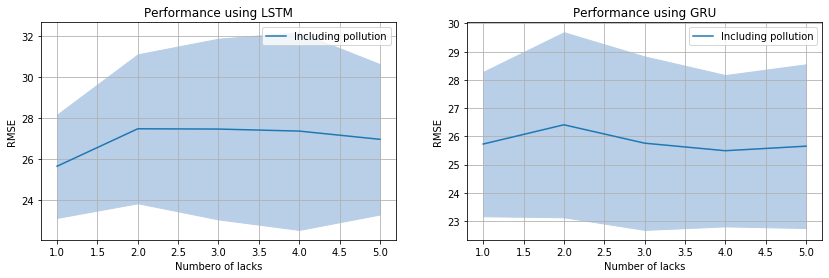

In [101]:
meanRMSE = np.mean(mse,axis=2)
stdRMSE =  np.std(mse,axis=2)
look_back = range(1,6)
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(14,4))
plt.subplot(121)
plt.plot(look_back,meanRMSE[0,:],label='Including pollution')
plt.fill_between(look_back, meanRMSE[0,:] + stdRMSE[0,:], meanRMSE[0,:] - stdRMSE[0,:], color="#b9cfe7", edgecolor="")
plt.xlabel('Numbero of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('Performance using LSTM')
plt.subplot(122)
plt.plot(look_back,meanRMSE[1,:],label='Including pollution')
plt.fill_between(look_back, meanRMSE[1,:] + stdRMSE[1,:], meanRMSE[1,:] - stdRMSE[1,:], color="#b9cfe7", edgecolor="")
plt.xlabel('Number of lacks')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title('Performance using GRU')

## Excercise 3

Create one model based on LSTM cells to predict air pollution [3,6,12] times ahead. Create a regular architecture and use the walk forward approach to make the predictions. Use a network with one LSTM layer of 50 cells.

Text(0.5,1,'Performance prediction for 3 times ahead using walk forward strategy')

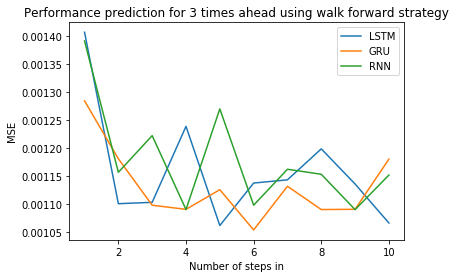

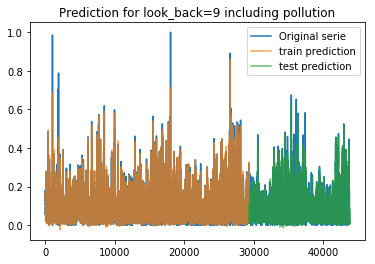